In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import sns
from mpmath.identification import transforms
from pytorch_lightning.callbacks import EarlyStopping
from tabulate import tabulate
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset,DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import neptune
from torchmetrics import Accuracy

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.cuda.empty_cache()

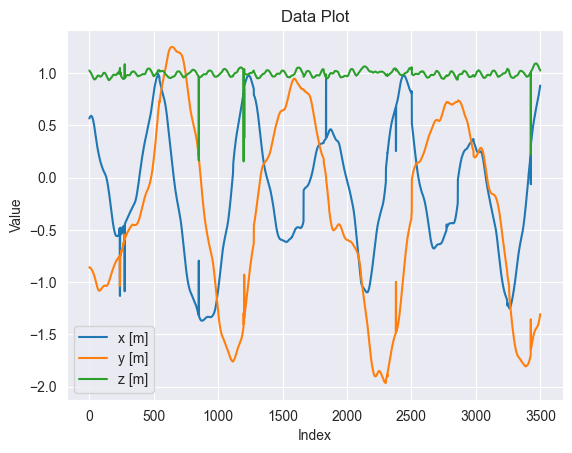

In [6]:
# Define the file path
file_path = r"54913.csv"


data = pd.read_csv(file_path, skipinitialspace=True)

# Plotting
plt.plot(data.index, data['x [m]'], label='x [m]')
plt.plot(data.index, data['y [m]'], label='y [m]')
plt.plot(data.index, data['z [m]'], label='z [m]')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Data Plot')
plt.legend()
plt.grid(True)

plt.show()

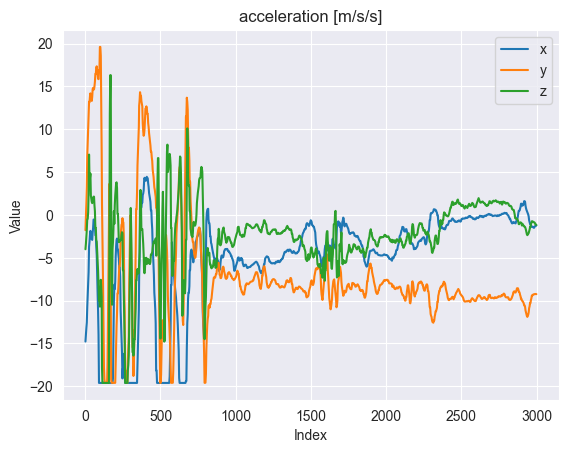

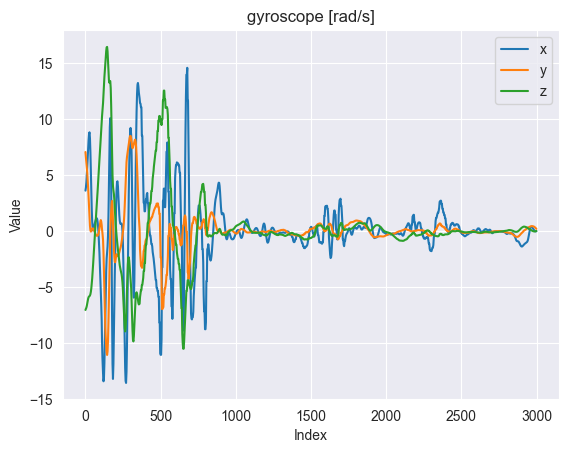

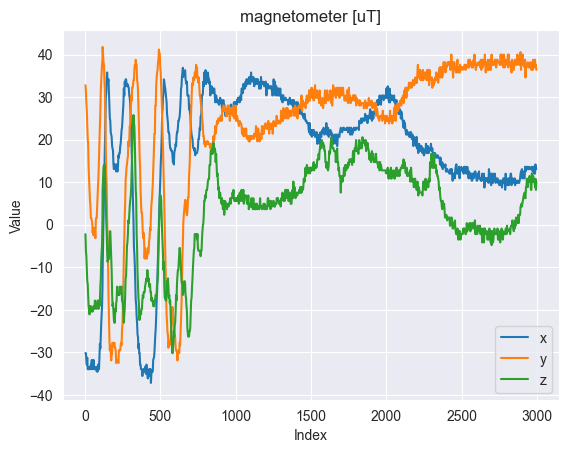

In [7]:
# Define the file path
file_path = r"2.csv"

# Read the data into a DataFrame
data = pd.read_csv(file_path, skipinitialspace=True)

# Group the data by measurement type
grouped_data = data.groupby('measurement type')

# Plot each measurement type separately
for key, group in grouped_data:
    plt.figure()
    plt.title(key)
    plt.plot(group['x'], label='x')
    plt.plot(group['y'], label='y')
    plt.plot(group['z'], label='z')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)

plt.show()


+-------------------------------+---------+---------------+
| activity                      |   Count |   Probability |
+===============================+=========+===============+
| walking_freely                |    4578 |    0.0937193  |
+-------------------------------+---------+---------------+
| walking_with_handbag          |    4510 |    0.0923272  |
+-------------------------------+---------+---------------+
| walking_holding_a_tray        |    4441 |    0.0909147  |
+-------------------------------+---------+---------------+
| walking_with_object_underarm  |    4412 |    0.090321   |
+-------------------------------+---------+---------------+
| using_phone                   |    4313 |    0.0882943  |
+-------------------------------+---------+---------------+
| walking_with_hands_in_pockets |    4243 |    0.0868613  |
+-------------------------------+---------+---------------+
| idle                          |    2675 |    0.0547617  |
+-------------------------------+-------

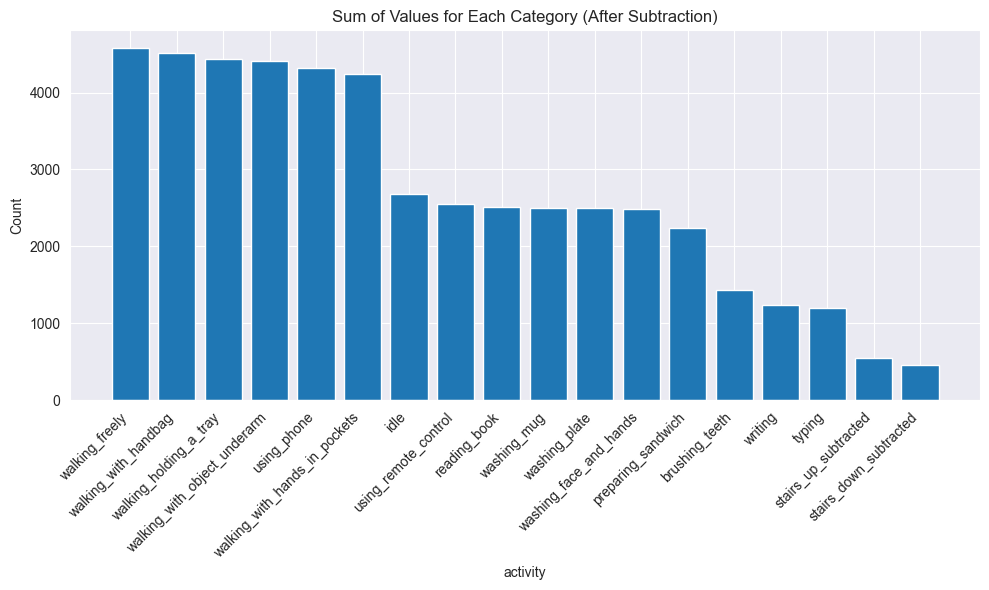

In [8]:
# List of categories
categories = [
    'stairs_up',
    'walking_with_hands_in_pockets',
    'walking_freely',
    'using_phone',
    'reading_book',
    'idle',
    'walking_with_object_underarm',
    'washing_mug',
    'walking_holding_a_tray',
    'washing_face_and_hands',
    'walking_with_handbag',
    'washing_plate',
    'using_remote_control',
    'typing',
    'preparing_sandwich',
    'writing',
    'stairs_down',
    'brushing_teeth'
]

# Read the CSV file into a DataFrame
train_path = r"C:\Users\nadav\Downloads\bgu-i-know-what-you-did-last-measurement-time\train\train.csv"
df = pd.read_csv(r"C:\Users\nadav\Downloads\bgu-i-know-what-you-did-last-measurement-time\train\train.csv")

# Subtract 700 samples from 'stairs_up' and 'stairs_down' categories
df_subtracted = df.copy()
df_subtracted.loc[df_subtracted['activity'] == 'stairs_up', 'activity'] = 'stairs_up_subtracted'
df_subtracted.loc[df_subtracted['activity'] == 'stairs_down', 'activity'] = 'stairs_down_subtracted'

# Calculate the sum of values for each category after subtraction
category_sum_subtracted = df_subtracted['activity'].value_counts()

category_sum_subtracted['stairs_up_subtracted'] -= 700
category_sum_subtracted['stairs_down_subtracted'] -= 700

# Total number of samples after subtraction
total_samples_subtracted = len(df) - 1400  

# Calculate probability for each category after subtraction
probabilities_subtracted = [(category, count / total_samples_subtracted) for category, count in category_sum_subtracted.items()]

# Create table data and sort it by count
table_data_subtracted = sorted([[category, count, prob] for (category, count), (_, prob) in zip(category_sum_subtracted.items(), probabilities_subtracted)], key=lambda x: x[1], reverse=True)

# Print the sorted table after subtraction
print(tabulate(table_data_subtracted, headers=['activity', 'Count', 'Probability'], tablefmt='grid'))

# Plot the data after subtraction
plt.figure(figsize=(10, 6))
categories_sorted_subtracted, sums_sorted_subtracted, probs_sorted_subtracted = zip(*table_data_subtracted)
plt.bar(categories_sorted_subtracted, sums_sorted_subtracted)
plt.title('Sum of Values for Each Category (After Subtraction)')
plt.xlabel('activity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



+-----------+---------+
| User ID   |   Count |
+===========+=========+
| user01    |    7387 |
+-----------+---------+
| user02    |    6102 |
+-----------+---------+
| user03    |    6492 |
+-----------+---------+
| user04    |    6348 |
+-----------+---------+
| user05    |    6262 |
+-----------+---------+
| user06    |    5571 |
+-----------+---------+
| user07    |    6331 |
+-----------+---------+
| user08    |    5755 |
+-----------+---------+


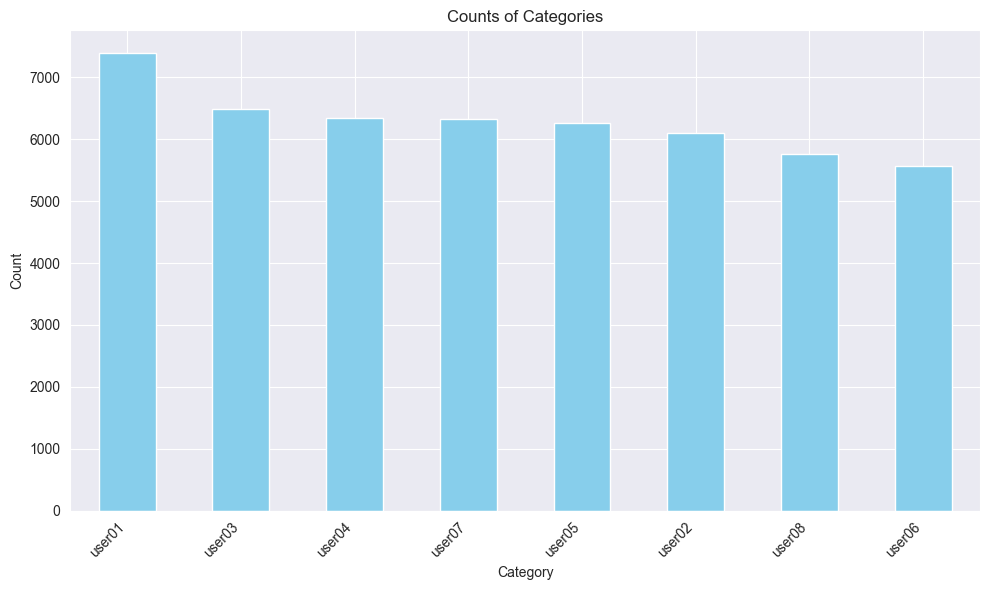

In [9]:
categories_users = ['user01', 'user02', 'user03', 'user04', 'user05', 'user06', 'user07', 'user08']
category_user = df['userid'].value_counts()

table_data = []
for category in categories_users:
    count = category_user.get(category, 0)
    table_data.append([category, count])

print(tabulate(table_data, headers=['User ID', 'Count'], tablefmt='grid'))

plt.figure(figsize=(10, 6))
category_user.plot(kind='bar', color='skyblue')
plt.title('Counts of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

In [10]:
activity_counts = df.groupby(['userid', 'activity']).size().unstack(fill_value=0)

table_data = []
for user in categories_users:
    counts = activity_counts.loc[user]
    table_data.append([user] + counts.tolist())

headers = ['User'] + activity_counts.columns.tolist()
print(tabulate(table_data, headers=headers, tablefmt='grid'))


+--------+------------------+--------+----------------------+----------------+---------------+-------------+----------+---------------+------------------------+------------------+--------------------------+------------------------+---------------------------------+--------------------------------+--------------------------+---------------+-----------------+-----------+
| User   |   brushing_teeth |   idle |   preparing_sandwich |   reading_book |   stairs_down |   stairs_up |   typing |   using_phone |   using_remote_control |   walking_freely |   walking_holding_a_tray |   walking_with_handbag |   walking_with_hands_in_pockets |   walking_with_object_underarm |   washing_face_and_hands |   washing_mug |   washing_plate |   writing |
+========+==================+========+======================+================+===============+=============+==========+===============+========================+==================+==========================+========================+=========================

+----+----------+--------------+---------+
|    | userid   |   smartwatch |   vicon |
+====+==========+==============+=========+
|  0 | user01   |         5862 |    1525 |
+----+----------+--------------+---------+
|  1 | user02   |         4527 |    1575 |
+----+----------+--------------+---------+
|  2 | user03   |         4429 |    2063 |
+----+----------+--------------+---------+
|  3 | user04   |         4474 |    1874 |
+----+----------+--------------+---------+
|  4 | user05   |         4540 |    1722 |
+----+----------+--------------+---------+
|  5 | user06   |         3955 |    1616 |
+----+----------+--------------+---------+
|  6 | user07   |         4324 |    2007 |
+----+----------+--------------+---------+
|  7 | user08   |         4075 |    1680 |
+----+----------+--------------+---------+


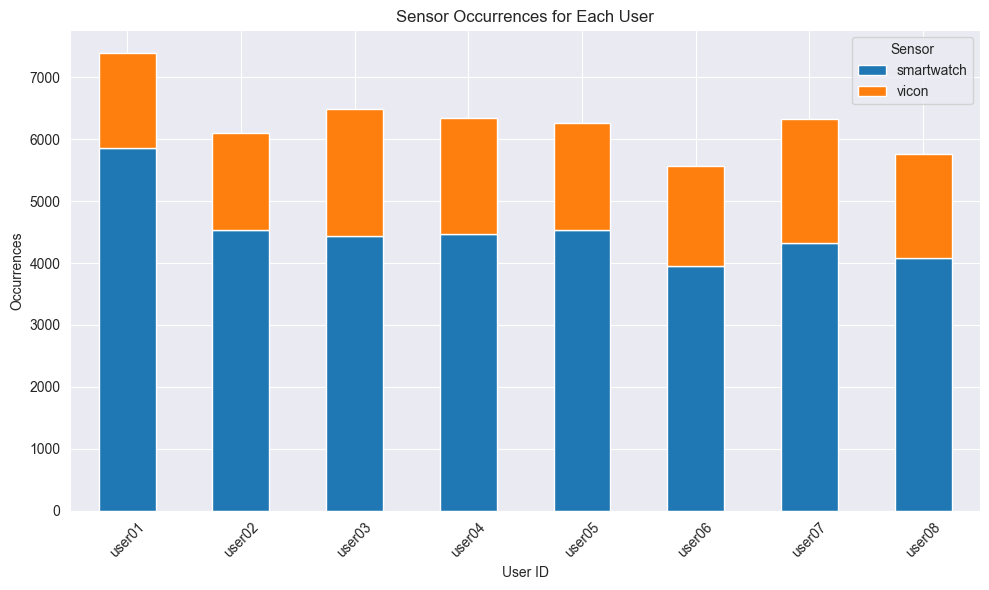

In [11]:
# Group by both 'userid' and 'sensor' and count occurrences
category_user_counts = df.groupby(['userid', 'sensor']).size().unstack(fill_value=0)

# Convert the DataFrame to a table format
table_data = category_user_counts.reset_index().rename_axis(columns={'sensor': 'User'})

# Print the table
print(tabulate(table_data, headers='keys', tablefmt='grid'))

# Plot the data
category_user_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sensor Occurrences for Each User')
plt.xlabel('User ID')
plt.ylabel('Occurrences')
plt.xticks(rotation=45)
plt.legend(title='Sensor')
plt.tight_layout()
plt.show()


+----------+--------+--------+
| userid   |   foot |   hand |
+==========+========+========+
| user01   |    774 |   6613 |
+----------+--------+--------+
| user02   |    773 |   5329 |
+----------+--------+--------+
| user03   |   1014 |   5478 |
+----------+--------+--------+
| user04   |    959 |   5389 |
+----------+--------+--------+
| user05   |    940 |   5322 |
+----------+--------+--------+
| user06   |    840 |   4731 |
+----------+--------+--------+
| user07   |   1077 |   5254 |
+----------+--------+--------+
| user08   |    775 |   4980 |
+----------+--------+--------+


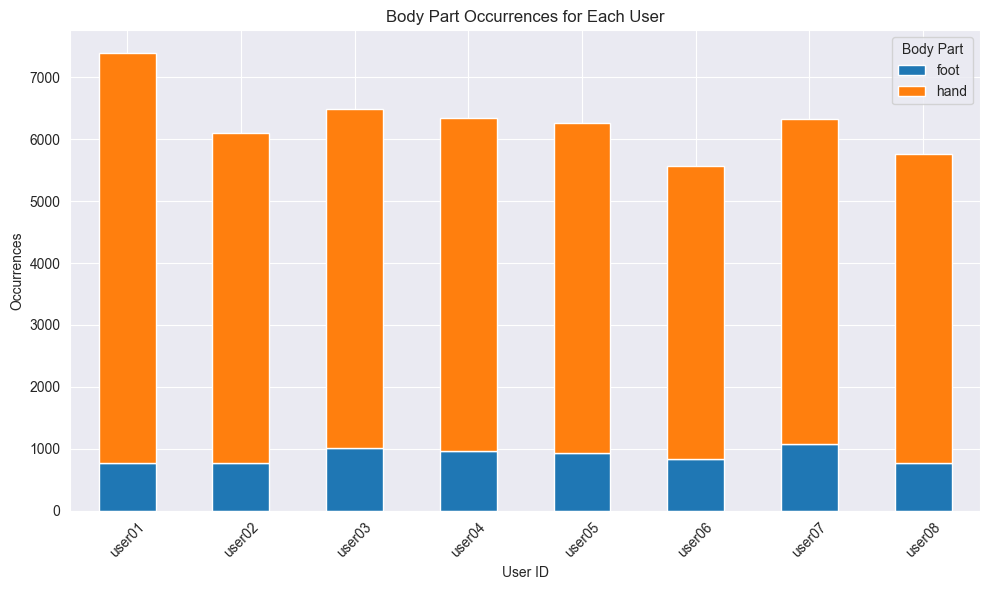

In [12]:
# Group by both 'userid' and 'body_part' and count occurrences
category_user_counts = df.groupby(['userid', 'body_part']).size().unstack(fill_value=0)

# Display the table
print(tabulate(category_user_counts, headers='keys', tablefmt='grid'))

# Plot the data
category_user_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Body Part Occurrences for Each User')
plt.xlabel('User ID')
plt.ylabel('Occurrences')
plt.xticks(rotation=45)
plt.legend(title='Body Part')
plt.tight_layout()
plt.show()

+----------+--------+---------+
| userid   |   left |   right |
+==========+========+=========+
| user01   |   2573 |    4814 |
+----------+--------+---------+
| user02   |   2750 |    3352 |
+----------+--------+---------+
| user03   |   3211 |    3281 |
+----------+--------+---------+
| user04   |   3006 |    3342 |
+----------+--------+---------+
| user05   |   2875 |    3387 |
+----------+--------+---------+
| user06   |   2560 |    3011 |
+----------+--------+---------+
| user07   |   3114 |    3217 |
+----------+--------+---------+
| user08   |   2777 |    2978 |
+----------+--------+---------+


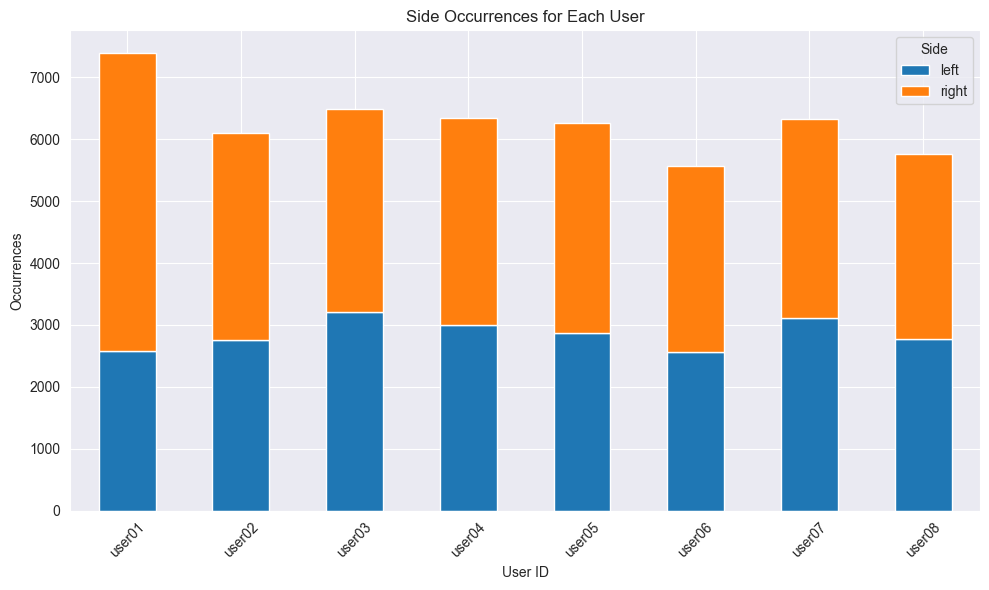

In [13]:
# Group by both 'userid' and 'side' and count occurrences
category_user_counts = df.groupby(['userid', 'side']).size().unstack(fill_value=0)

# Display the table
print(tabulate(category_user_counts, headers='keys', tablefmt='grid'))

# Plot the data
category_user_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Side Occurrences for Each User')
plt.xlabel('User ID')
plt.ylabel('Occurrences')
plt.xticks(rotation=45)
plt.legend(title='Side')
plt.tight_layout()
plt.show()

+----------+--------+--------+--------+
| userid   |   3000 |   3500 |   4000 |
+==========+========+========+========+
| user01   |   2507 |   2493 |   2387 |
+----------+--------+--------+--------+
| user02   |   2046 |   2045 |   2011 |
+----------+--------+--------+--------+
| user03   |   2242 |   2145 |   2105 |
+----------+--------+--------+--------+
| user04   |   2187 |   2112 |   2049 |
+----------+--------+--------+--------+
| user05   |   2156 |   2071 |   2035 |
+----------+--------+--------+--------+
| user06   |   1889 |   1889 |   1793 |
+----------+--------+--------+--------+
| user07   |   2152 |   2117 |   2062 |
+----------+--------+--------+--------+
| user08   |   1965 |   1916 |   1874 |
+----------+--------+--------+--------+


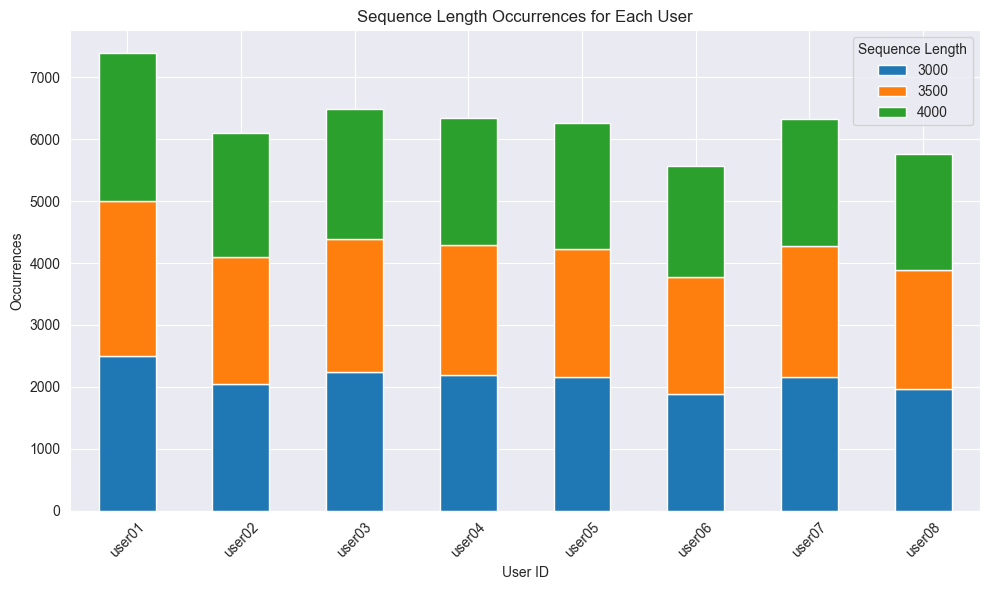

In [14]:
# Group by both 'userid' and 'sequence_length' and count occurrences
category_user_counts = df.groupby(['userid', 'sequence_length']).size().unstack(fill_value=0)

# Display the table
print(tabulate(category_user_counts, headers='keys', tablefmt='grid'))

# Plot the data
category_user_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Sequence Length Occurrences for Each User')
plt.xlabel('User ID')
plt.ylabel('Occurrences')
plt.xticks(rotation=45)
plt.legend(title='Sequence Length')
plt.tight_layout()
plt.show()

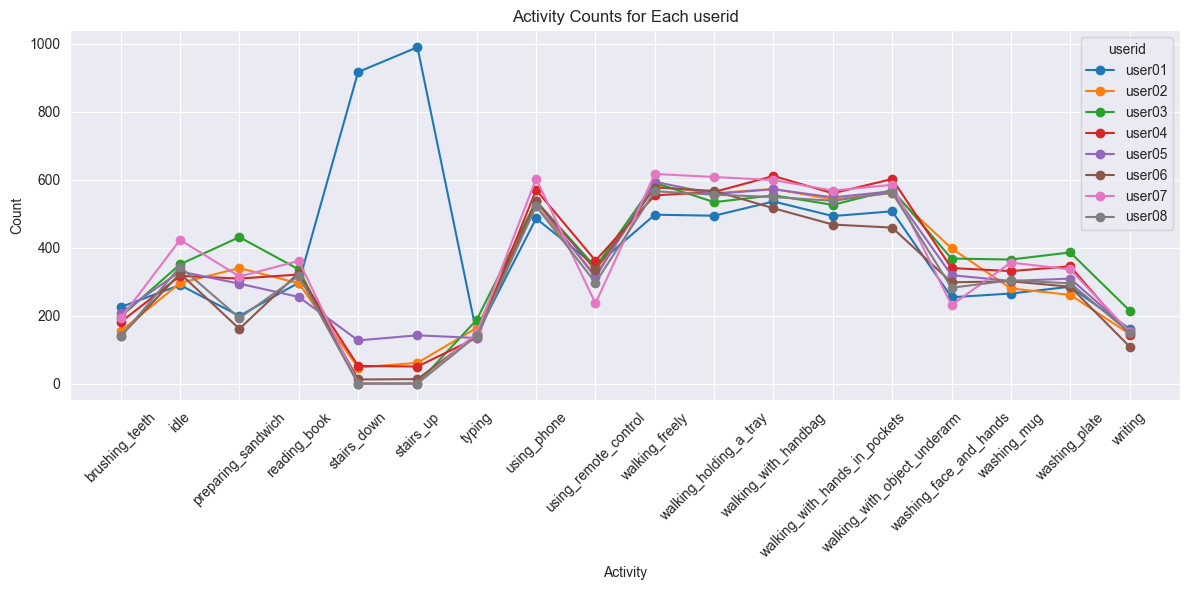

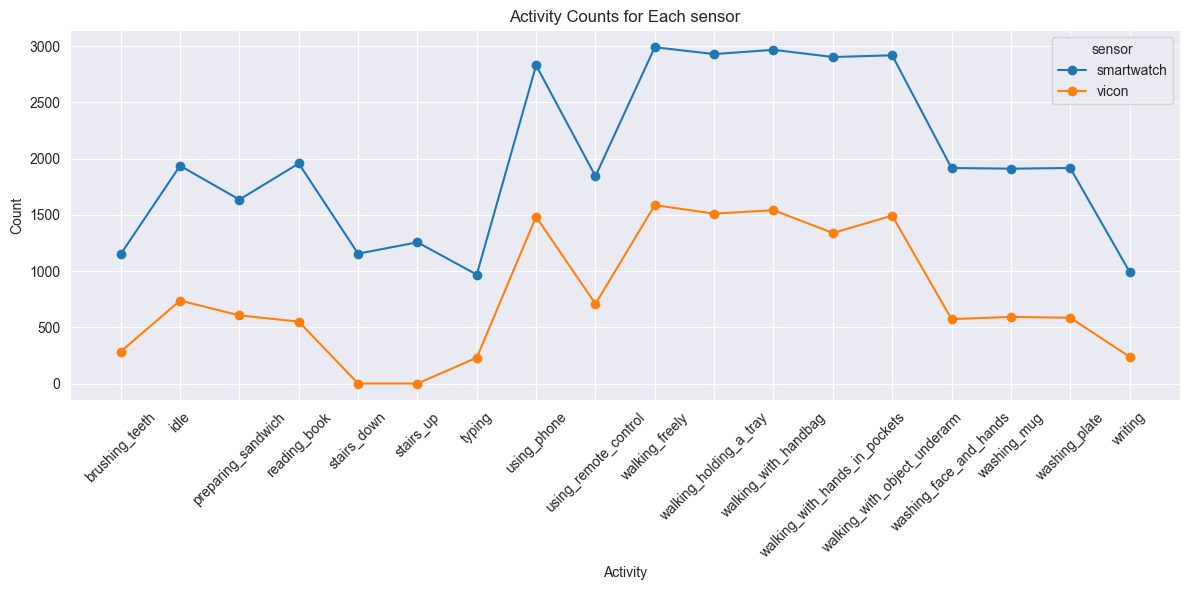

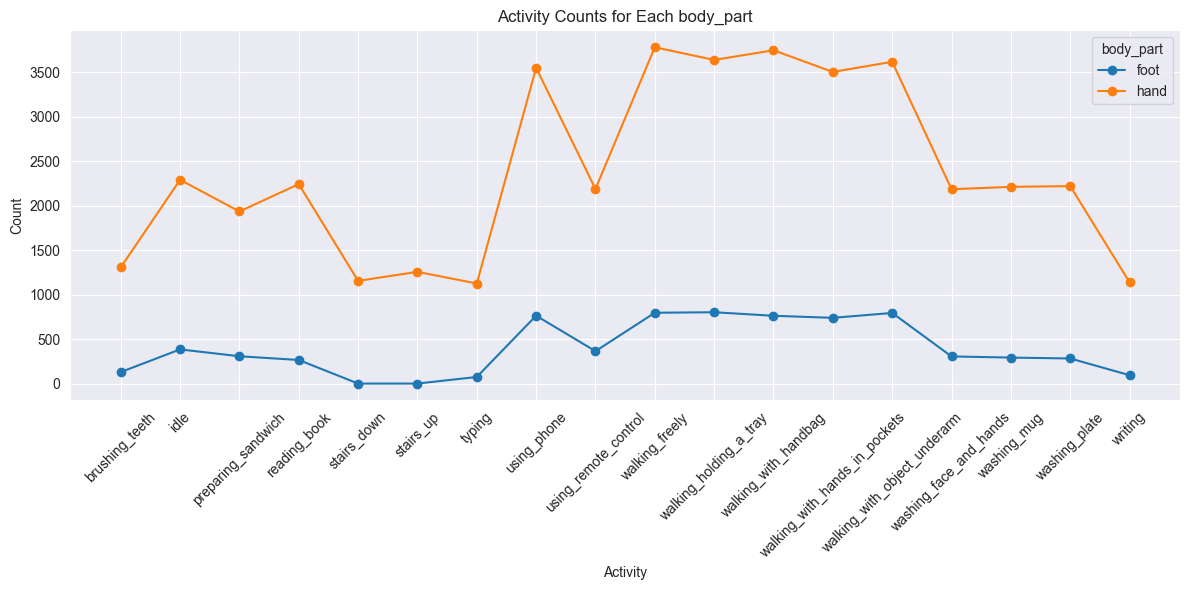

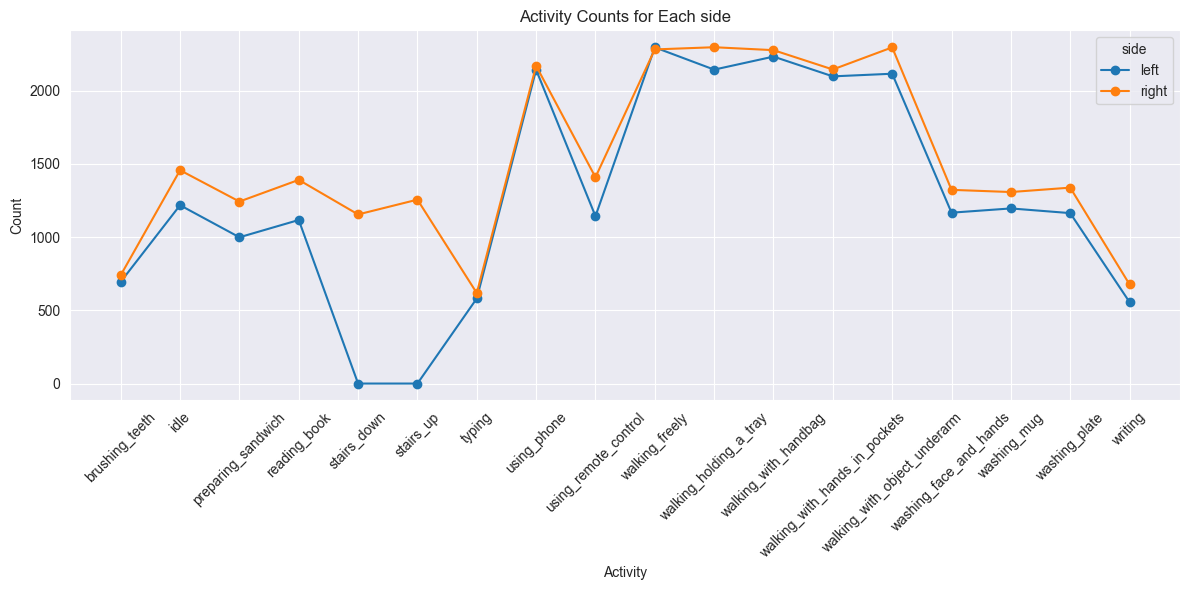

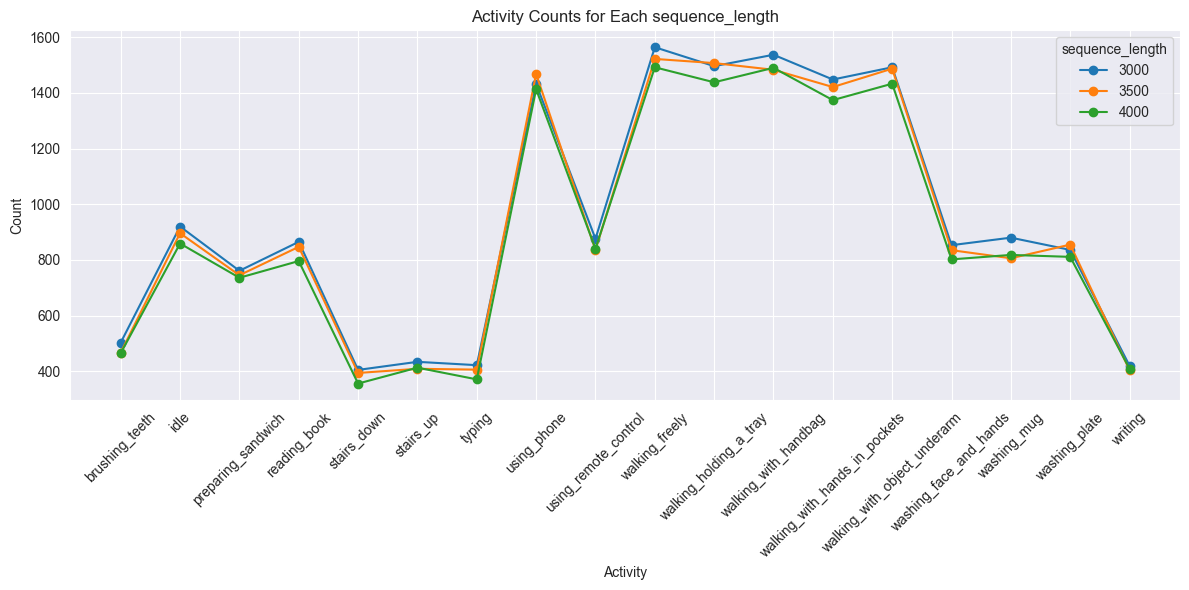

In [15]:
# Assuming df is your DataFrame containing the data

# List of categorical columns
categorical_columns = ['userid','sensor', 'body_part', 'side', 'sequence_length']

# Loop through each categorical column
for col in categorical_columns:
    # Cross-tabulation
    ct = pd.crosstab(df[col], df['activity'])
    
    # Plot
    plt.figure(figsize=(12, 6))
    for category in ct.index:
        plt.plot(ct.columns, ct.loc[category], label=category, marker='o')

    plt.title(f'Activity Counts for Each {col}')
    plt.xlabel('Activity')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title=col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [40]:
import pandas as pd
import numpy as np

# max_vicon = [[-float('inf'), -float('inf'), -float('inf')] for _ in range(3)]
# min_vicon = [[float('inf'), float('inf'), float('inf')] for _ in range(3)]
# max_sw = [[-float('inf'), -float('inf'), -float('inf')] for _ in range(3)]
# min_sw = [[float('inf'), float('inf'), float('inf')] for _ in range(3)]
mean_vicon = [0, 0, 0]
std_vicon = [0, 0, 0]
mean_sw = [0, 0, 0]
std_sw = [0, 0, 0]
count_vicon = 0
count_sw = 0

def DataForTree():
    global mean_vicon, std_vicon, mean_sw, std_sw, count_vicon, count_sw
    df = pd.read_csv(r"C:\Users\nadav\Downloads\bgu-i-know-what-you-did-last-measurement-time\train\train.csv")
    # df = pd.read_excel(r"user01.xlsx")
    for index, row in df.iterrows():
        num = row['id']
        num_df = pd.read_csv(r"C:\Users\nadav\Downloads\bgu-i-know-what-you-did-last-measurement-time\unlabeled"+f'/{num}.csv')
        
        if row['sensor'] == 'vicon':
            # for i, axis in enumerate(['x [m]', 'y [m]', 'z [m]']):
            #     max_vicon_temp = num_df[axis].nlargest(3).values
            #     min_vicon_temp = num_df[axis].nsmallest(3).values
            #     max_vicon[i] = np.maximum(max_vicon[i], max_vicon_temp)
            #     min_vicon[i] = np.minimum(min_vicon[i], min_vicon_temp)
            # max_vicon_temp = num_df.max().values
            # min_vicon_temp = num_df.min().values
            # global max_vicon, min_vicon
            # max_vicon = np.maximum(max_vicon, max_vicon_temp)
            # min_vicon = np.minimum(min_vicon, min_vicon_temp)
            mean = num_df.mean().values
            std = num_df.std().values
            df.at[index, 'mean x'] = mean[0]
            df.at[index, 'mean y'] = mean[1]
            df.at[index, 'mean z'] = mean[2]
            df.at[index, 'std x'] = std[0]
            df.at[index, 'std y'] = std[1]
            df.at[index, 'std z'] = std[2]
            for i in range(3):
                mean_vicon[i] += mean[i]
                std_vicon[i] += std[i]
            count_vicon += 1
        else:
            # acceleration_data = num_df[num_df['measurement type'] == 'acceleration [m/s/s]']
        # Select only the 'x', 'y', and 'z' columns
            acceleration_data = num_df[num_df['measurement type'] == 'acceleration [m/s/s]']
        # Select only the 'x', 'y', and 'z' columns
            matrix = acceleration_data[['x', 'y', 'z']]
            # for i, axis in enumerate(['x', 'y', 'z']):
            #     max_sw_temp = acceleration_data[axis].nlargest(3).values
            #     min_sw_temp = acceleration_data[axis].nsmallest(3).values
            #     max_sw[i] = np.maximum(max_sw[i], max_sw_temp)
            #     min_sw[i] = np.minimum(min_sw[i], min_sw_temp)
            # max_sw_temp = matrix.max().values
            # min_sw_temp = matrix.min().values
            # global max_sw, min_sw
            # max_sw = np.maximum(max_sw, max_sw_temp)
            # min_sw = np.minimum(min_sw, min_sw_temp)
            mean = matrix.mean().values
            std = matrix.std().values
            df.at[index, 'mean x'] = mean[0]
            df.at[index, 'mean y'] = mean[1]
            df.at[index, 'mean z'] = mean[2]
            df.at[index, 'std x'] = std[0]
            df.at[index, 'std y'] = std[1]
            df.at[index, 'std z'] = std[2]
            for i in range(3):
                mean_sw[i] += mean[i]
                std_sw[i] += std[i]
            count_sw += 1
    df.to_excel('classicML_with_id.xlsx', index=False)
    df.drop(columns=['id'], inplace=True)
    # Save the DataFrame back to an Excel file
    df['activity'], _ = pd.factorize(df['activity'])
    df['sensor'], _ = pd.factorize(df['sensor'])
    df['body_part'], _ = pd.factorize(df['body_part'])
    df['side'], _ = pd.factorize(df['side'])
    df.to_excel('classic_ML_to_train.xlsx', index=False)
    return df

In [41]:
data = DataForTree()

In [42]:
# Print the min-max values for Vicon and Smartwatch
print("mean_vicon values for Vicon:", mean_vicon)
print("std_vicon values for Vicon:", std_vicon)
print("mean_sw values for Smartwatch:", mean_sw)
print("std_sw values for Smartwatch:", std_sw)
print("count vicon: ", count_vicon)
print("count sw: ", count_sw)

mean_vicon values for Vicon: [-2225.2313369467115, -4094.9077767275544, 8180.637418967848]
std_vicon values for Vicon: [7260.064168603126, 9244.29725384127, 1963.6151654296511]
mean_sw values for Smartwatch: [-6859.866706998431, -188155.77666975404, 21850.294149411973]
std_sw values for Smartwatch: [76859.53370523933, 74212.42385786682, 78655.03046385075]
count vicon:  14062
count sw:  36186


In [45]:
mean_vicon_avg = [mean / count_vicon for mean in mean_vicon]
mean_sw_avg = [mean / count_sw for mean in mean_sw]

In [46]:
std_vicon_avg = [std / count_vicon for std in std_vicon]
std_sw_avg = [std / count_sw for std in std_sw]

In [47]:
print("mean of means vicon: ", mean_vicon_avg)
print("mean of std vifon: ", std_vicon_avg)
print("mean of means sw: ", mean_sw_avg)
print("mean of std sw: ", std_sw_avg)


mean of means vicon:  [-0.15824429931351952, -0.29120379581336614, 0.5817549010786409]
mean of std vifon:  [0.5162895867304171, 0.6573956232286496, 0.13963982117975046]
mean of means sw:  [-0.18957239559493813, -5.199684316303378, 0.6038328123973905]
mean of std sw:  [2.124012980302861, 2.0508601077175377, 2.1736315277690474]


In [50]:
data

,Unnamed: 0,userid,activity,sensor,body_part,side,sequence_length,mean x,mean y,mean z,std x,std y,std z
0,0,user01,0,0,0,0,3000,9.854024,-3.627803,0.290560,2.805462,1.881018,1.153312
1,1,user01,1,0,0,1,4000,-6.008387,-5.667247,-5.050316,1.323015,2.869353,2.250978
2,2,user08,1,0,0,0,3000,7.749479,-6.483315,-0.195027,1.682312,2.887200,2.243103
3,3,user01,2,0,0,0,3000,10.526714,-2.482579,-0.031363,1.857634,1.524470,2.224719
4,4,user07,3,1,0,1,4000,-0.360914,0.255268,1.037768,0.509472,0.728815,0.186860
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50243,50243,user01,1,0,0,0,3500,7.133913,-7.151110,-0.441042,1.783720,2.738587,1.961468
50244,50244,user01,17,0,0,0,3000,-2.209061,-5.968076,-1.049005,4.367271,5.152155,6.377270
50245,50245,user01,7,0,0,1,3000,-0.056054,-4.812181,3.882246,2.609926,4.849439,6.980697
50246,50246,user03,2,1,0,0,4000,-0.194574,-0.445208,0.945526,0.705727,0.998882,0.104752


In [38]:
import torch

def add_noise(matrix, noise_std=0.1, add_noise=True):
    if add_noise:
        noise = torch.randn_like(matrix) * noise_std
        matrix = matrix + noise  # Assign the noisy tensor back to matrix
    return matrix

# Example usage
original_matrix = torch.tensor([[1.1, 2.2, 3.3],
                                [4.4, 5.5, 6.6],
                                [7.7, 8.8, 9.9]])

print("Original Matrix:")
print(original_matrix)

# Add Gaussian noise to the matrix
noise = torch.randn_like(original_matrix) * 0.1
original_matrix += noise

print("Original Matrix:")
print(original_matrix)

print("\nNoisy Matrix:")
print(original_matrix)



Original Matrix:
tensor([[1.1000, 2.2000, 3.3000],
        [4.4000, 5.5000, 6.6000],
        [7.7000, 8.8000, 9.9000]])
Original Matrix:
tensor([[1.0359, 2.2628, 3.2793],
        [4.4147, 5.5038, 6.7033],
        [7.6480, 8.7969, 9.7457]])

Noisy Matrix:
tensor([[1.0359, 2.2628, 3.2793],
        [4.4147, 5.5038, 6.7033],
        [7.6480, 8.7969, 9.7457]])


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
# keep in mind we have to normalize our inputs!
df_train = DataForTree()
X_train, X_test, y_train, y_test = train_test_split(df_train, df_label, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the SVC model
model = SVC(kernel='linear')

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


In [2]:
class SensorsDataset_test(torch.utils.data.Dataset):
    def __init__(self, root_path, transforms=None, test=False, noise_std=0.1, vicon=True):
        super().__init__()

        self.transforms = transforms
        self.measurement = []
        self.root_path = root_path
        self.num = 0
        self.test = test
        self.vicon = vicon
        self.noise_std = noise_std  # Standard deviation of Gaussian noise
        self.categories = {
            'brushing_teeth': 0,
            'idle': 1,
            'preparing_sandwich': 2,
            'reading_book': 3,
            'stairs_down': 4,
            'stairs_up': 5,
            'typing': 6,
            'using_phone': 7,
            'using_remote_control': 8,
            'walking_freely': 9,
            'walking_holding_a_tray': 10,
            'walking_with_handbag': 11,
            'walking_with_hands_in_pockets': 12,
            'walking_with_object_underarm': 13,
            'washing_face_and_hands': 14,
            'washing_mug': 15,
            'washing_plate': 16,
            'writing': 17
        }
        self.inverted_categories = {v: k for k, v in self.categories.items()}

        if test:
            df = pd.read_csv(root_path)

        else:
            df = pd.read_excel(root_path)

        for index, row in df.iterrows():

            if test:
                info_tuple = (row['sample_id'])
                df_num = pd.read_csv(r"C:\Users\nadav\Downloads\bgu-i-know-what-you-did-last-measurement-time\unlabeled"
                                     + f'/{int(info_tuple)}.csv')

                num_columns = df_num.shape[1]
                if (num_columns == 3 and vicon) or (num_columns != 3 and not vicon):
                    self.measurement.append(int(info_tuple))
                del df_num
            else:
                if (vicon and row['sensor'] == 'vicon') or (not vicon and row['sensor'] != 'vicon'):
                    info_tuple = (row['id'], row['activity'])
                    self.measurement.append(info_tuple)

        del df

    def __len__(self):
        return len(self.measurement)

    def __getitem__(self, idx):
        if self.test:
            self.num = self.measurement[idx]
        else:
            self.num = self.measurement[idx][0]
        if not self.test:
            label = self.measurement[idx][-1]
        else:
            label = 'stairs_up'

        df = pd.read_csv(
            r"C:\Users\nadav\Downloads\bgu-i-know-what-you-did-last-measurement-time\unlabeled" + f'/{self.num}.csv')

        num_columns = df.shape[1]
        if num_columns == 3:  # vicon sensor
            matrix = df.iloc[:, :].values
            # matrix = self.min_max_normalize(matrix, min_values=[-2.18780933, -3.32152953, -0.97645178],
            # max_values=[7.28087119, 3.9842868, 4.76762667])
            # matrix = self.z_score_normalize(matrix, [-0.15824429931351952, -0.29120379581336614, 0.5817549010786409],
            #                                 [0.5162895867304171, 0.6573956232286496, 0.13963982117975046])
        else:  # smartwatch sensor
            acceleration_data = df[df['measurement type'] == 'acceleration [m/s/s]']
            matrix = acceleration_data[['x', 'y', 'z']]
            matrix = matrix.values
            # matrix = self.z_score_normalize(matrix, mean, std)
            # matrix = self.min_max_normalize(matrix, min_values=[-19.603912, -19.594337, -19.603912],
            #                                 max_values=[19.594337, 19.603912, 19.594337])
            # matrix = self.z_score_normalize(matrix, [-0.18957239559493813, -5.199684316303378, 0.6038328123973905],
            #                                 [2.124012980302861, 2.0508601077175377, 2.1736315277690474])

        if self.transforms:
            matrix = self.transforms(matrix)

        # Padding
        matrix = torch.tensor(matrix, dtype=torch.float32)

        # Add Gaussian noise to the matrix
        if not self.test:
            noise = torch.randn_like(matrix) * self.noise_std
            matrix += noise

        if self.vicon:
            pad_length = (4000 - len(matrix)) // 2
        else:
            pad_length = (1450 - len(matrix)) // 2

        if pad_length > 0:
            matrix = F.pad(matrix, (0, 0, pad_length, pad_length), mode='constant', value=0)

        del df
        return matrix, self.categories[label], self.num

    def min_max_normalize(self, matrix, min_values, max_values):
        # Clip values for each axis separately
        for i in range(matrix.shape[1]):  # Iterate over each axis
            matrix[:, i] = np.clip(matrix[:, i], min_values[i], max_values[i])

        # Min-max normalization for each axis
        for i in range(matrix.shape[1]):  # Iterate over each axis
            matrix[:, i] = (matrix[:, i] - min_values[i]) / (max_values[i] - min_values[i])
        return matrix

    def z_score_normalize(self, matrix, mean_values, std_values):
        # Z-score normalization for each axis
        for i in range(matrix.shape[1]):  # Iterate over each axis
            matrix[:, i] = (matrix[:, i] - mean_values[i]) / std_values[i]
        return matrix

In [3]:
class SensorsDatasetPadding4000(torch.utils.data.Dataset):
    def _init_(self, root_path, transforms=None, test=False):
        super()._init_()

        self.transforms = transforms
        self.measurement = []
        self.root_path = root_path
        self.test = test
        self.num = 0
        df = pd.read_excel(root_path)
        # Iterate over the rows of the DataFrame
        for index, row in df.iterrows():
            # Extract the required information and create a tuple
            info_tuple = (row['id'], row['sensor'], row['activity'])
            
            # Append the tuple to the list
            self.measurement.append(info_tuple)


    def _len_(self):
        return len(self.measurement)

    def _getitem_(self, idx):
        how_many_to_mean = 100
        self.num = self.measurement[idx][0]
        label = self.measurement[idx][-1]
        df = pd.read_csv(r"C:\Users\nadav\Downloads\bgu-i-know-what-you-did-last-measurement-time\unlabeled"+f'/{self.num}.csv')
        if self.measurement[idx][1] == 'vicon':
            # Extract numerical data from the DataFrame
            matrix = df.iloc[:, :].values
            mean = np.mean(matrix[-how_many_to_mean:,:], axis=0)
            slopex = (((matrix[len(matrix)-1][0] - matrix[len(matrix)-100][0])/100) + ((matrix[len(matrix)-1][0] - matrix[len(matrix)-60][0])/60) + ((matrix[len(matrix)-1][0] - matrix[len(matrix)-30][0])/30))
            slopey = (((matrix[len(matrix)-1][1] - matrix[len(matrix)-100][1])/100) + ((matrix[len(matrix)-1][1] - matrix[len(matrix)-60][1])/60) + ((matrix[len(matrix)-1][1] - matrix[len(matrix)-30][1])/30))
            slopez = (((matrix[len(matrix)-1][2] - matrix[len(matrix)-100][2])/100) + ((matrix[len(matrix)-1][2] - matrix[len(matrix)-60][2])/60) + ((matrix[len(matrix)-1][2] - matrix[len(matrix)-30][2])/30))
            while len(matrix) != 4000:
                matrix = np.append(matrix,[mean],axis=0)
                mean[0] = mean[0]*slopex
                mean[1] = mean[1]*slopey
                mean[2] = mean[2]*slopez
        else:
            # Filter rows where measurement type is "acceleration"
            acceleration_data = df[df['measurement type'] == 'acceleration [m/s/s]']
            # Select only the 'x', 'y', and 'z' columns
            matrix = acceleration_data[['x', 'y', 'z']]
            matrix = matrix.values
            mean = np.mean(matrix[-how_many_to_mean:,:], axis=0)
            slopex = (((matrix[len(matrix)-1][0] - matrix[len(matrix)-100][0])/100) + ((matrix[len(matrix)-1][0] - matrix[len(matrix)-60][0])/60) + ((matrix[len(matrix)-1][0] - matrix[len(matrix)-30][0])/30))
            slopey = (((matrix[len(matrix)-1][1] - matrix[len(matrix)-100][1])/100) + ((matrix[len(matrix)-1][1] - matrix[len(matrix)-60][1])/60) + ((matrix[len(matrix)-1][1] - matrix[len(matrix)-30][1])/30))
            slopez = (((matrix[len(matrix)-1][2] - matrix[len(matrix)-100][2])/100) + ((matrix[len(matrix)-1][2] - matrix[len(matrix)-60][2])/60) + ((matrix[len(matrix)-1][2] - matrix[len(matrix)-30][2])/30))
            while len(matrix) != 4000:
                matrix = np.append(matrix,[mean],axis=0)
                mean[0] = mean[0]*slopex
                mean[1] = mean[1]*slopey
                mean[2] = mean[2]*slopez
            
            
        if self.transforms:
            matrix = self.transforms(matrix)
        if self.test:
            return matrix, categories[label], self.num
        else:
            return matrix, categories[label]

In [4]:
class CNN(pl.LightningModule):
    def __init__(self, train_data, val_data, test_data, data_dir='./data_folder/', num_classes=18, learning_rate=2e-4,
                 batch_size=64):
        super().__init__()

        self.run = neptune.init_run(
            project="nadavcherry/dp1",
            api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlf"
                      "dXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyNTVhY"
                      "zkxZC1jOTc3LTQ4ZjYtOGFhZC00MzljZmVlOGFhYWEifQ==",  # your credentials
        )

        self.categories = {
            'brushing_teeth': 0,
            'idle': 1,
            'preparing_sandwich': 2,
            'reading_book': 3,
            'stairs_down': 4,
            'stairs_up': 5,
            'typing': 6,
            'using_phone': 7,
            'using_remote_control': 8,
            'walking_freely': 9,
            'walking_holding_a_tray': 10,
            'walking_with_handbag': 11,
            'walking_with_hands_in_pockets': 12,
            'walking_with_object_underarm': 13,
            'washing_face_and_hands': 14,
            'washing_mug': 15,
            'washing_plate': 16,
            'writing': 17
        }
        self.inverted_categories = {v: k for k, v in self.categories.items()}
        # Set our init args as class attributes

        self.test_dataloader1 = test_data
        self.train_dataloader1 = train_data
        self.val_dataloader1 = val_data
        self.data_dir = data_dir
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        # Hardcode some dataset specific attributes
        self.count = 0
        self.z = [i for i in range(-1, 18)]
        self.z[0] = 'sample_id'
        self.df = pd.DataFrame(columns=self.z)
        self.num_classes = num_classes
        self.y = []
        self.preds = []

        self.conv2 = nn.Conv1d(3, 64, 1, stride=1)
        self.conv3 = nn.Conv1d(64, 128, 1, stride=1)
        self.conv4 = nn.Conv1d(128, 64, 1, stride=1)
        self.conv5 = nn.Conv1d(64, 32, 1, stride=1)
        self.conv6 = nn.Conv1d(32, 64, 1, stride=1)
        self.linear1 = nn.Linear(64 * 500, 50)
        self.linear2 = nn.Linear(50, self.num_classes)
        self.mp = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.val_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.train_accuracy = Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv2(x))
        x = self.mp(x)  # Pooling reduces dimension by factor of 2
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.mp(x)  # Pooling reduces dimension by factor of 2
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.mp(x)  # Pooling reduces dimension by factor of 2

        # Calculate the correct size after pooling layers
        # Initial length is 4000, and we apply max pooling 3 times with a factor of 2
        final_length = 4000 // (2 ** 3)  # Adjust depending on the exact operations and input size

        # Assuming the final number of channels before the linear layer is 64
        final_channels = 64  # This matches the output channels of the last conv layer
        final_features = final_channels * final_length

        x = x.view(-1, final_features)  # Reshape to match the size before linear layer

        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y, _ = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.train_accuracy.update(preds, y)
        self.run["train/loss"].log(loss.item())
        self.run["train/accuracy"].log(self.train_accuracy.compute())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, _ = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        self.run["val/loss"].log(loss.item())
        self.run["val/accuracy"].log(self.val_accuracy.compute())
        self.log("val/val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        if batch_idx == 0:
            self.y = []
            self.preds = []
        for i in range(len(y)):
            self.y.append(y[i])
            self.preds.append(preds[i])
        return loss

    def test_step(self, batch, batch_idx):
        x, _, ids = batch
        logits = self(x)
        probs = F.softmax(logits, dim=1)
        for i in range(probs.size(0)):  # Iterate over batch dimension
            for j in range(probs.size(1)):  # Iterate over class dimension
                class_name = self.z[j + 1]
                self.df.loc[i + self.count, class_name] = probs[i, j].item()
                self.df.loc[i + self.count, 'sample_id'] = ids[i].item()
        self.count += probs.size(0)

    def on_test_end(self):
        file_path = f'output hidden_size'
        self.df.rename(columns=self.inverted_categories, inplace=True)
        self.df.to_csv(file_path, index=False)
        self.run[f"{file_path}"].upload(file_path)
        # self.run[f"best_model.ckpt"].upload("checkpoints/best_model.ckpt")
        try:
            folder_path = "lightning_logs"
            version_list = os.listdir(folder_path)
            # Extract numerical part of each version
            version_numbers = [int(version.split('_')[1]) for version in version_list]

            # Select the largest version number
            latest_version_number = max(version_numbers)

            # Construct the latest version string
            latest_version = f"version_{latest_version_number}"
            version = latest_version + '/checkpoints'
            file_path = os.listdir(folder_path + '/' + version)
            f = str(folder_path + '/' + version + '/' + file_path[0])
            self.run[f"{file_path[0]}"].upload(f)
            cm = confusion_matrix(self.y, self.preds)

            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, cmap='Greens', annot=True, fmt='d')
            plt.xlabel('Prediction')
            plt.ylabel('True label')
            plt.title('ASL Convolutional Model\nClassification Results on Test Set')

            # Save the confusion matrix plot
            cm_plot_path = 'confusion_matrix_plot.png'
            plt.savefig(cm_plot_path)
            plt.close()
            self.run[f'Confusion_Matrix_Plot'].upload(cm_plot_path)
        except:
            print("not good")
        self.run.stop()

    def train_dataloader(self):
        return self.train_dataloader1

    def val_dataloader(self):
        return self.val_dataloader1

    def test_dataloader(self):
        return self.test_dataloader1

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

In [11]:
# # Dictionary of categories mapped to indices
    train_path = r"C:\Users\nadav\Downloads\bgu-i-know-what-you-did-last-measurement-time\train\train.csv"

    # train_dataset_vicon = SensorsDataset_test("merged5.xlsx", test=False, vicon=True)
    # # with open("train_dataset_vicon.pickle", "wb") as f:
    # #     pickle.dump(train_dataset_vicon, f)
    # val_dataset_vicon = SensorsDataset_test("user05.xlsx", test=False, vicon=True)
    # # with open("val_dataset_vicon.pickle", "wb") as f1:
    # #     pickle.dump(val_dataset_vicon, f1)
    # merged_data_test_vicon = SensorsDataset_test('sample_submission.csv', test=True, vicon=True)
    # # with open("merged_data_test_vicon.pickle", "wb") as f2:
    # #     pickle.dump(merged_data_test_vicon, f2)

    with open("train_dataset_vicon.pickle", "rb") as f1: #####TO LOAD FILE
        train_dataset_vicon = pickle.load(f1)
    with open("val_dataset_vicon.pickle", "rb") as f2: #####TO LOAD FILE
        val_dataset_vicon = pickle.load(f2)
    with open("merged_data_test_vicon.pickle", "rb") as f3: #####TO LOAD FILE
        merged_data_test_vicon = pickle.load(f3)

    # with open("instance.pickle", "rb") as f6: #####TO LOAD FILE
    #     loaded_obj = pickle.load(f6)
    val_dataset_vicon.noise_std = 0
    merged_data_test_vicon.noise_std = 0

    train_loader_vicon = DataLoader(train_dataset_vicon, batch_size=64, shuffle=True, num_workers=20,
                                    persistent_workers=True)
    val_loader_vicon = DataLoader(val_dataset_vicon, batch_size=64, num_workers=25, persistent_workers=True,
                                  shuffle=True)
    test_loader_vicon = DataLoader(merged_data_test_vicon, batch_size=128)

    x_vicon = [(256, 1, 0.5, False),]
    x_sw = [(256, 1, 0.5, False)]

    torch.set_float32_matmul_precision('medium')
    torch.cuda.empty_cache()

    for params in x_vicon:
        torch.cuda.empty_cache()
        kf_model_vicon = None
        hidden, layers, drop, bidir = params
        torch.cuda.empty_cache()
        print("starting LSTM_vicon with parameters: ", hidden, layers, drop, bidir)
        kf_model_vicon = CNN(train_loader_vicon, val_loader_vicon, test_loader_vicon)

        early_stop_callback = EarlyStopping(
            monitor='val/val_loss',
            min_delta=0.001,
            patience=3,
            verbose=True,
            mode='min'
        )
        trainer = pl.Trainer(
            accelerator="auto",
            max_epochs=20,
            callbacks=[early_stop_callback],  # , checkpoint_callback
        )
        trainer.fit(kf_model_vicon)
        trainer.test(kf_model_vicon)
    train_loader_vicon = None
    val_loader_vicon = None
    test_loader_vicon = None

    # train_dataset_sw = SensorsDataset_test("merged5.xlsx", test=False, vicon=False)
    # # with open("train_dataset_sw.pickle", "wb") as f3:
    # #     pickle.dump(train_dataset_sw, f3)
    # val_dataset_sw = SensorsDataset_test("user05.xlsx", test=False, vicon=False)
    # # with open("val_dataset_sw.pickle", "wb") as f4:
    # #     pickle.dump(val_dataset_sw, f4)
    # merged_data_test_sw = SensorsDataset_test('sample_submission.csv', test=True, vicon=False)
    # # with open("merged_data_test_sw.pickle", "wb") as f5:
    # #     pickle.dump(merged_data_test_sw, f5)

    with open("train_dataset_sw.pickle", "rb") as f4: #####TO LOAD FILE
        train_dataset_sw = pickle.load(f4)
    with open("val_dataset_sw.pickle", "rb") as f5: #####TO LOAD FILE
        val_dataset_sw = pickle.load(f5)
    with open("merged_data_test_sw.pickle", "rb") as f6: #####TO LOAD FILE
        merged_data_test_sw = pickle.load(f6)

    train_loader_sw = DataLoader(train_dataset_sw, batch_size=64, shuffle=True, num_workers=10, persistent_workers=True)
    val_loader_sw = DataLoader(val_dataset_sw, batch_size=64, num_workers=20, persistent_workers=True, shuffle=True)
    test_loader_sw = DataLoader(merged_data_test_sw, batch_size=128)
    val_dataset_sw.noise_std = 0
    merged_data_test_sw.noise_std = 0

    for params in x_sw:
        torch.cuda.empty_cache()
        kf_model_sw = None
        hidden, layers, drop, bidir = params
        torch.cuda.empty_cache()
        print("starting LSTM_vicon with parameters: ", hidden, layers, drop, bidir)
        kf_model_sw = CNN(train_loader_sw, val_loader_sw, test_loader_sw)

        early_stop_callback = EarlyStopping(
            monitor='val/val_loss',
            min_delta=0.001,
            patience=3,
            verbose=True,
            mode='min'
        )
        trainer = pl.Trainer(
            accelerator="auto",
            max_epochs=20,
            callbacks=[early_stop_callback],  # , checkpoint_callback
        )
        trainer.fit(kf_model_sw)
        trainer.test(kf_model_sw)


In [12]:
class SensorsDataset_test(torch.utils.data.Dataset):
    def __init__(self, root_path, transforms=None, test=False, noise_std=0.1, vicon=True):
        super().__init__()

        self.transforms = transforms
        self.measurement = []
        self.root_path = root_path
        self.num = 0
        self.test = test
        self.vicon = vicon
        self.noise_std = noise_std  # Standard deviation of Gaussian noise
        self.categories = {
            'brushing_teeth': 0,
            'idle': 1,
            'preparing_sandwich': 2,
            'reading_book': 3,
            'stairs_down': 4,
            'stairs_up': 5,
            'typing': 6,
            'using_phone': 7,
            'using_remote_control': 8,
            'walking_freely': 9,
            'walking_holding_a_tray': 10,
            'walking_with_handbag': 11,
            'walking_with_hands_in_pockets': 12,
            'walking_with_object_underarm': 13,
            'washing_face_and_hands': 14,
            'washing_mug': 15,
            'washing_plate': 16,
            'writing': 17
        }
        self.inverted_categories = {v: k for k, v in self.categories.items()}

        if test:
            df = pd.read_csv(root_path)
        else:
            df = pd.read_excel(root_path)

        for index, row in df.iterrows():

            if test:
                info_tuple = (row['sample_id'])
                df_num = pd.read_csv(r"C:\Users\nadav\Downloads\bgu-i-know-what-you-did-last-measurement-time\unlabeled"
                                     + f'/{int(info_tuple)}.csv')

                num_columns = df_num.shape[1]
                if (num_columns == 3 and vicon) or (num_columns != 3 and not vicon):
                    self.measurement.append(int(info_tuple))
                del df_num
            else:
                if (vicon and row['sensor'] == 'vicon') or (not vicon and row['sensor'] != 'vicon'):
                    info_tuple = (row['id'], row['activity'])
                    self.measurement.append(info_tuple)

        del df

    def __len__(self):
        return len(self.measurement)

    def __getitem__(self, idx):
        if self.test:
            self.num = self.measurement[idx]
        else:
            self.num = self.measurement[idx][0]
        if not self.test:
            label = self.measurement[idx][-1]
        else:
            label = 'stairs_up'

        df = pd.read_csv(
            r"C:\Users\nadav\Downloads\bgu-i-know-what-you-did-last-measurement-time\unlabeled" + f'/{self.num}.csv')

        num_columns = df.shape[1]
        if num_columns == 3:  # vicon sensor
            matrix = df.iloc[:, :].values
            # matrix = self.min_max_normalize(matrix, min_values=[-2.18780933, -3.32152953, -0.97645178],
            # max_values=[7.28087119, 3.9842868, 4.76762667])
            # matrix = self.z_score_normalize(matrix, [-0.15824429931351952, -0.29120379581336614, 0.5817549010786409],
            #                                 [0.5162895867304171, 0.6573956232286496, 0.13963982117975046])
        else:  # smartwatch sensor
            acceleration_data = df[df['measurement type'] == 'acceleration [m/s/s]']
            matrix = acceleration_data[['x', 'y', 'z']]
            matrix = matrix.values
            # matrix = self.z_score_normalize(matrix, mean, std)
            # matrix = self.min_max_normalize(matrix, min_values=[-19.603912, -19.594337, -19.603912],
            #                                 max_values=[19.594337, 19.603912, 19.594337])
            # matrix = self.z_score_normalize(matrix, [-0.18957239559493813, -5.199684316303378, 0.6038328123973905],
            #                                 [2.124012980302861, 2.0508601077175377, 2.1736315277690474])

        if self.transforms:
            matrix = self.transforms(matrix)

        # Padding
        matrix = torch.tensor(matrix, dtype=torch.float32)

        # Add Gaussian noise to the matrix
        # if not self.test:
        #     noise = torch.randn_like(matrix) * self.noise_std
        #     matrix += noise

        if self.vicon:
            pad_length = 4000 - len(matrix)
        else:
            pad_length = 1450 - len(matrix)
        if pad_length > 0:
            matrix = F.pad(matrix, (0, 0, pad_length, 0), mode='constant', value=0)
        del df
        return matrix, self.categories[label], self.num


In [13]:
class LSTM(pl.LightningModule):
    def __init__(self, input_size, hidden_size, output_size, train_dataloader, val_dataloader, test_dataloader):
        super().__init__()
        self.run = neptune.init_run(
        project="nadavcherry/dp1",
        capture_hardware_metrics=True,
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlf"
              "dXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyNTVhY"
              "zkxZC1jOTc3LTQ4ZjYtOGFhZC00MzljZmVlOGFhYWEifQ==", # your credentials
        )
        self.train_dataloader1 = train_dataloader
        self.val_dataloader1 = val_dataloader
        self.test_dataloader1 = test_dataloader

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.num_layers = 3
        self.dropout = 0.2
        
        # self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        # self.fc = nn.Linear(hidden_size, output_size)
                # Define LSTM layers
        # Define bidirectional LSTM layers
        self.lstm_layers = nn.ModuleList([
            nn.LSTM(input_size if i == 0 else 2 * hidden_size, hidden_size, batch_first=True, bidirectional=True)
            for i in range(self.num_layers)
        ])

        # Define dropout layer
        self.dropout_layer = nn.Dropout(self.dropout)

        # Define final fully connected layer
        self.fc = nn.Linear(2 * hidden_size, output_size)
        # Define bidirectional LSTM layers
        # self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        # self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, batch_first=True, bidirectional=True)
        # 
        # self.linear1 = nn.Linear(hidden_size * 2, hidden_size * 2)
        # self.linear2 = nn.Linear(hidden_size * 2, hidden_size * 2)
        # 
        # self.linear_aux_out = nn.Linear(hidden_size * 2, output_size)
        # 
        # self.dropout_layer = nn.Dropout(self.dropout)     
        # 
        self.train_accuracy = Accuracy(task="multiclass", num_classes=18)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=18)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=18)

        self.preds = []
        self.y = []
        self.z = [i for i in range(-1,18)]
        self.z[0] = 'sample_id'
        self.df = pd.DataFrame(columns=self.z)
        self.count = 0
    # def forward(self, x):
    #     batch_size, seq_len, _ = x.size()
    #     
    #     h_lstm1, _ = self.lstm1(x)
    #     h_lstm2, _ = self.lstm2(h_lstm1)
    #     
    #     # global average pooling
    #     avg_pool = torch.mean(h_lstm2, 1)
    #     # global max pooling
    #     max_pool, _ = torch.max(h_lstm2, 1)
    #     
    #     h_conc = torch.cat((max_pool, avg_pool), 1)
    #     h_conc_linear1  = F.relu(self.linear1(h_conc))
    #     h_conc_linear2  = F.relu(self.linear2(h_conc))
    #     
    #     hidden = h_conc + h_conc_linear1 + h_conc_linear2
    #     
    #     aux_result = self.linear_aux_out(hidden)
    #     
    #     # Return 18 separate outputs
    #     return aux_result


    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        # Forward pass through bidirectional LSTM layers
        for lstm_layer in self.lstm_layers:
            out, _ = lstm_layer(x)
            x = out  # Output of one layer is input to the next

        # Apply dropout
        # out = self.dropout_layer(out)

        # Final output layer
        out = self.fc(out[:, -1, :])  # Taking the output from the last time step
        return out


    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.train_accuracy.update(preds, y)
        self.run["train/loss"].log(loss.item())
        self.run["train/accuracy"].log(self.train_accuracy.compute())
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        self.run["val/loss"].log(loss.item())
        self.run["val/accuracy"].log(self.val_accuracy.compute())
        
        self.log("val/val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, _, ids = batch
        logits = self(x)
        logits = logits.cpu()
        # y = y.cpu()
        # loss = F.cross_entropy(logits, y)
        
        # preds = torch.argmax(logits, dim=1)
        probs = F.softmax(logits, dim=1)       
        # self.test_accuracy.update(preds, y)
        # self.run["test/loss"].log(loss.item())
        # self.run["test/accuracy"].log(self.test_accuracy.compute())
        # self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        # self.log("test_acc", self.test_accuracy, on_step=False, on_epoch=True, prog_bar=True)
        
        # for i in range(len(y)):    
        #     self.y.append(y[i])
        #     self.preds.append(preds[i])

        for i in range(probs.size(0)):  # Iterate over batch dimension
            # print("start for")
            
            for j in range(probs.size(1)):  # Iterate over class dimension
                class_name = self.z[j+1]
                prob = probs[i, j]
                # print(f"Sample {i}: Probability of {class_name}: {prob.item()}")
                self.df.loc[i+self.count, class_name] = probs[i, j].item()
                self.df.loc[i+self.count, 'sample_id'] = ids[i].item()
                # lf.df = np.append(matrix,[mean],axis=0)
        self.count += probs.size(0)

        # return loss



    def on_test_end(self):
        # cm = confusion_matrix(self.y, self.preds)
        # 
        # plt.figure(figsize=(10, 8))
        # sns.heatmap(cm, cmap='Greens', annot=True, fmt='d')
        # plt.xlabel('Prediction')
        # plt.ylabel('True label')
        # plt.title('ASL Convolutional Model\nClassification Results on Test Set')
        # 
        # # Save the confusion matrix plot
        # cm_plot_path = 'confusion_matrix_plot.png'
        # plt.savefig(cm_plot_path)
        # plt.close()
        # 
        # 
        # folder_path = "lightning_logs"
        # version_list = os.listdir(folder_path)
        # # Extract numerical part of each version
        # version_numbers = [int(version.split('_')[1]) for version in version_list]
        # 
        # # Select the largest version number
        # latest_version_number = max(version_numbers)
        # 
        # # Construct the latest version string
        # # latest_version = f"version_{latest_version_number}"
        # # version = latest_version + '/checkpoints'
        # # file_path = os.listdir(folder_path+'/'+version)
        # # f = str(folder_path+'/'+version+'/'+file_path[0])
        # # self.run[f"{file_path[0]}"].upload(f)   
        # self.run[f'Confusion_Matrix_Plot'].upload(cm_plot_path)
        self.run.stop()
    
    def train_dataloader(self):
        return self.train_dataloader1

    def val_dataloader(self):
        return self.val_dataloader1

    def test_dataloader(self):
        return self.test_dataloader1

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=2e-4)

In [ ]:
class LSTM(pl.LightningModule):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout, bidirectional, train_dataloader,
                 val_dataloader, test_dataloader):
        super().__init__()
        self.run = neptune.init_run(
            project="nadavcherry/dp1",
            capture_hardware_metrics=True,
            api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlf"
                      "dXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyNTVhY"
                      "zkxZC1jOTc3LTQ4ZjYtOGFhZC00MzljZmVlOGFhYWEifQ==",  # your credentials
            tags=f"hidden_size: {hidden_size}, num_layers: {num_layers}, dropout: {dropout}, bidirectional: {bidirectional}",
        )
        self.train_dataloader1 = train_dataloader
        self.val_dataloader1 = val_dataloader
        self.test_dataloader1 = test_dataloader

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = output_size
        self.num_layers = num_layers
        self.dropout_r = dropout
        self.bidirectional = bidirectional
        self.categories = {
            'brushing_teeth': 0,
            'idle': 1,
            'preparing_sandwich': 2,
            'reading_book': 3,
            'stairs_down': 4,
            'stairs_up': 5,
            'typing': 6,
            'using_phone': 7,
            'using_remote_control': 8,
            'walking_freely': 9,
            'walking_holding_a_tray': 10,
            'walking_with_handbag': 11,
            'walking_with_hands_in_pockets': 12,
            'walking_with_object_underarm': 13,
            'washing_face_and_hands': 14,
            'washing_mug': 15,
            'washing_plate': 16,
            'writing': 17
        }
        self.inverted_categories = {v: k for k, v in self.categories.items()}
        self.train_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=self.num_classes)
        self.preds = []
        self.y = []
        self.z = [i for i in range(-1, 18)]
        self.z[0] = 'sample_id'
        self.df = pd.DataFrame(columns=self.z)
        self.count = 0

        # GRU layer
        self.gru = nn.GRU(input_size=input_size,
                          hidden_size=hidden_size,
                          batch_first=True,
                          num_layers=self.num_layers,
                          dropout=self.dropout_r,
                          bias=True)

        # Fully connected layers
        self.fc_1 = nn.Linear(in_features=hidden_size, out_features=hidden_size * 2)
        self.fc_2 = nn.Linear(in_features=hidden_size * 2, out_features=hidden_size)
        self.fc = nn.Linear(in_features=hidden_size, out_features=self.num_classes)

        # Activation function and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(self.dropout_r)

        # Batch normalization
        self.bn1 = nn.BatchNorm1d(hidden_size * 2)
        self.bn2 = nn.BatchNorm1d(hidden_size)

    def forward(self, x):
        self.gru.flatten_parameters()

        # Forward pass through GRU layer
        out, hn = self.gru(x)

        # Select the output from the last time step
        out = out[:, -1, :]

        # Fully connected layers
        out = self.fc_1(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc_2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc(out)
        return out


    def training_step(self, batch, batch_idx):
        x, y, _ = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.train_accuracy.update(preds, y)
        self.run["train/loss"].log(loss.item())
        self.run["train/accuracy"].log(self.train_accuracy.compute())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, _ = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)
        self.run["val/loss"].log(loss.item())
        self.run["val/accuracy"].log(self.val_accuracy.compute())
        self.log("val/val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        for i in range(len(y)):
            self.y.append(y[i])
            self.preds.append(preds[i])
        return loss

    def on_validation_epoch_end(self):
        try:
            cm = confusion_matrix(self.y, self.preds)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, cmap='Greens', annot=True, fmt='d')
            plt.xlabel('Prediction')
            plt.ylabel('True label')
            plt.title('ASL Convolutional Model\nClassification Results on Test Set')
            # Save the confusion matrix plot
            cm_plot_path = 'confusion_matrix_plot.png'
            plt.savefig(cm_plot_path)
            plt.close()
            self.run[f'Confusion_Matrix_Plot'].upload(cm_plot_path)
            self.y = []
            self.preds = []
        except:
            print("not good")



    def test_step(self, batch, batch_idx):
        x, _, ids = batch
        logits = self(x)
        probs = F.softmax(logits, dim=1)
        for i in range(probs.size(0)):  # Iterate over batch dimension
            for j in range(probs.size(1)):  # Iterate over class dimension
                class_name = self.z[j + 1]
                self.df.loc[i + self.count, class_name] = probs[i, j].item()
                self.df.loc[i + self.count, 'sample_id'] = ids[i].item()
        self.count += probs.size(0)

    def on_test_end(self):
        # self.run[f"best_model.ckpt"].upload("checkpoints/best_model.ckpt")
        try:
            file_path = f'output hidden_size-{self.hidden_size} num_layers-{self.num_layers} dropout-{self.dropout} bidirectional-{self.bidirectional}.csv'
            # Save the DataFrame to Excel
            self.df.rename(columns=self.inverted_categories, inplace=True)
            self.df.to_csv(file_path, index=False)
            self.run[f"{file_path}"].upload(file_path)
        except:
            print("not good")
        self.run.stop()

    def train_dataloader(self):
        return self.train_dataloader1

    def val_dataloader(self):
        return self.val_dataloader1

    def test_dataloader(self):
        return self.test_dataloader1

    def configure_optimizers(self):
        if self.bidirectional:
            return torch.optim.Adam(self.parameters())
        else:
            return torch.optim.Adagrad(self.parameters())

In [ ]:
train_dataset_vicon = SensorsDataset_test("merged5.xlsx", test=False, vicon=True)
    val_dataset_vicon = SensorsDataset_test("user05.xlsx", test=False, vicon=True)
    merged_data_test_vicon = SensorsDataset_test('sample_submission.csv', test=True, vicon=True)
    val_dataset_vicon.noise_std = 0
    merged_data_test_vicon.noise_std = 0

    train_loader_vicon = DataLoader(train_dataset_vicon, batch_size=64, shuffle=True, num_workers=7,
                                    persistent_workers=True)
    val_loader_vicon = DataLoader(val_dataset_vicon, batch_size=64, num_workers=20, persistent_workers=True,
                                  shuffle=True)
    test_loader_vicon = DataLoader(merged_data_test_vicon, batch_size=128)

    x_vicon = [(400,2,0.5,True), (300,2,0.5,True)]

    #(256, 1, 0.5, True), (256, 1, 0.25, True), (128, 1, 0.5, True), (128, 1, 0.25, True),

    x_sw = [(256, 1, 0.25, True), (512, 1, 0.75, False)]

    # (256, 1, 0.5, False), (256, 1, 0.75, False),
    #(256, 1, 0.5, True), (256, 1, 0.75, True),

    torch.set_float32_matmul_precision('medium')
    torch.cuda.empty_cache()
    #
    count = 110
    for params in x_vicon:
        torch.cuda.empty_cache()
        kf_model_vicon = None
        hidden, layers, drop, bidir = params
        torch.cuda.empty_cache()
        print("starting LSTM_vicon with parameters: ", hidden, layers, drop, bidir, count)
        kf_model_vicon = LSTM(input_size=3, hidden_size=hidden, output_size=18, num_layers=layers, dropout=drop,
                              bidirectional=bidir, train_dataloader=train_loader_vicon, val_dataloader=val_loader_vicon,
                              test_dataloader=test_loader_vicon)

        checkpoint_callback = ModelCheckpoint(
            monitor='val/val_loss',
            mode='min',
            save_top_k=1,  # Save only the best model
            dirpath=f'checkpoints{count}/',
            filename='best_model-{epoch:02d}-{val/val_loss:.2f}'
        )
        early_stop_callback = EarlyStopping(
            monitor='val/val_loss',
            min_delta=0.001,
            patience=6,
            verbose=True,
            mode='min'
        )

        # Setup your trainer with the ModelCheckpoint callback
        trainer = pl.Trainer(
            callbacks=[checkpoint_callback, early_stop_callback],
            max_epochs=35,
            accelerator='auto'
            # include any other parameters you need
        )

        # Train your model
        trainer.fit(kf_model_vicon)

        # Load the best model
        kf_model_vicon.load_state_dict(torch.load(checkpoint_callback.best_model_path)['state_dict'])

        # Now, perform the test with the best model
        trainer.test(kf_model_vicon)
        count += 1
    train_loader_vicon = None
    val_loader_vicon = None
    test_loader_vicon = None

    # with open("train_dataset_sw_2.pickle", "rb") as f4: #####TO LOAD FILE
    #     train_dataset_sw = pickle.load(f4)
    # with open("val_dataset_sw_2.pickle", "rb") as f5:  #####TO LOAD FILE
    #     val_dataset_sw = pickle.load(f5)
    # with open("merged_data_test_sw.pickle", "rb") as f6: #####TO LOAD FILE
    #     merged_data_test_sw = pickle.load(f6)
    train_dataset_sw = SensorsDataset_test("merged5.xlsx", test=False, vicon=False)
    val_dataset_sw = SensorsDataset_test("user05.xlsx", test=False, vicon=False)
    merged_data_test_sw = SensorsDataset_test('sample_submission.csv', test=True, vicon=False)

    train_loader_sw = DataLoader(train_dataset_sw, batch_size=64, shuffle=True, num_workers=7, persistent_workers=True)
    val_loader_sw = DataLoader(val_dataset_sw, batch_size=64, num_workers=20, persistent_workers=True, shuffle=True)
    test_loader_sw = DataLoader(merged_data_test_sw, batch_size=128)

    val_dataset_sw.noise_std = 0
    merged_data_test_sw.noise_std = 0

    for params in x_sw:
        torch.cuda.empty_cache()
        kf_model_sw = None
        hidden, layers, drop, bidir = params
        torch.cuda.empty_cache()
        print("starting LSTM_vicon with parameters: ", hidden, layers, drop, bidir, count)
        kf_model_sw = LSTM(input_size=3, hidden_size=hidden, output_size=18, num_layers=layers, dropout=drop,
                           bidirectional=bidir, train_dataloader=train_loader_sw, val_dataloader=val_loader_sw,
                           test_dataloader=test_loader_sw)

        checkpoint_callback = ModelCheckpoint(
            monitor='val/val_loss',
            mode='min',
            save_top_k=1,  # Save only the best model
            dirpath=f'checkpoints{count}/',
            filename='best_model-{epoch:02d}-{val/val_loss:.2f}'
        )

        early_stop_callback = EarlyStopping(
            monitor='val/val_loss',
            min_delta=0.001,
            patience=5,
            verbose=True,
            mode='min'
        )

        # Setup your trainer with the ModelCheckpoint callback
        trainer = pl.Trainer(
            callbacks=[checkpoint_callback, early_stop_callback],
            max_epochs=40,
            accelerator='auto'
            # include any other parameters you need
        )

        # Train your model
        trainer.fit(kf_model_sw)

        # Load the best model
        kf_model_sw.load_state_dict(torch.load(checkpoint_callback.best_model_path)['state_dict'])

        # Now, perform the test with the best model
        trainer.test(kf_model_sw)
        count += 1